In [2]:
%config Completer.use_jedi = False


In [3]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc
import os
from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof

In [4]:
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing


In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

In [7]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/mechanical'#modflow model
os.chdir(wdir)

In [8]:
minerals = ["Q", "P", "K", "B", "O", "A"]

modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00000001, 0.11877509]])  # WA

csds_means = np.array([[0.120, 0.174, 0.112, 0.155, 0.066, 0.079],
                       [0.247, 0.333, 0.292, 0.212, 0.090, 0.127],
                       [0.309, 0.330, 0.244, 0.223, 0.120, 0.122],
                       [0.244, 0.269, 0.222, 0.251, 0.059, 0.107],
                       [0.220, 0.227, 0.160, 0.153, 0.078, 0.075],
                       [0.342, 0.385, 0.241, 0.481, 0.001, 0.130]])

csds_stds = np.array([[0.359, 0.356, 0.455, 0.399, 0.328, 0.452],
                      [0.986, 0.640, 0.497, 0.889, 0.275, 0.502],
                      [0.823, 0.683, 0.817, 0.819, 0.554, 0.782],
                      [0.312, 0.450, 0.444, 0.262, 0.378, 0.313],
                      [0.472, 0.415, 0.344, 0.363, 0.315, 0.599],
                      [0.542, 0.478, 0.386, 0.467, 0.001, 0.494]])




In [9]:
def plutonname(i):
    if i == 0:
        return 'AZ'
    elif i == 1:
        return 'CA_EW'
    elif i == 2:
        return 'CA_NS'
    elif i == 3:
        return 'GR'
    elif i == 4:
        return 'MT'
    elif i == 5: 
        return 'WA'

In [46]:
def lineplotpcgmcg(pluton, sedgenmech):
    fig, ax = plt.subplots()
    ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
    ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)

    ax.text(70, 12, "mcg", color=sns.color_palette()[1], fontsize=12)
    ax.text(70, 2.5, "pcg", color=sns.color_palette()[0], fontsize=12)

    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.set_xlim(0, 77)
    ax.spines['bottom'].set_bounds(0, 77)
    ax.spines['left'].set_bounds(0, 14)
    ax.spines['left'].set_position(('outward', 10))
    # Set general tick parameters
    ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)
    ax.set_title('pcg,mcg'+ pluton)
    ax.set_xlabel("Timesteps", color='grey')
    ax.set_ylabel("$\log_{10}$n", rotation=0, labelpad=20, color='grey')
    # Set facecolor of figure
    plt.gcf().set_facecolor('white')
    sns.despine()
    # plt.legend()
    plt.tight_layout()
    if sedgenmech == "sedgen_mech":
        plt.savefig('lineplot_pcgmcg_evolution_mech' + pluton +'.png')
    else:
        plt.savefig('lineplot_pcgmcg_evolution_chem+mech' + pluton +'.png')
    plt.show()

In [47]:
def lineplotchemweath(pluton, sedgenchem, sedgen):
    fig, ax = plt.subplots() 

    for i in range(6):
        ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
    
    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(0, 100)
    ax.set_ylim(4.5, 8.5)

    ax.spines['bottom'].set_bounds(0, 100)
    ax.spines['left'].set_bounds(4.5, 8.5)

    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 5))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)

    ax.set_xlabel("Timesteps", color='grey')
    ax.set_ylabel("$\log_{10}$V", rotation=0, labelpad=20, color='grey')

    # ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    if sedgenchem == "sedgen_chem":
        plt.savefig("lineplot_volume_residue_chem"+pluton+".png")
    else:
        plt.savefig("lineplot_volume_residue_chem+mech"+pluton+".png")
    plt.show();


---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -2
all good K 0
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 85 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


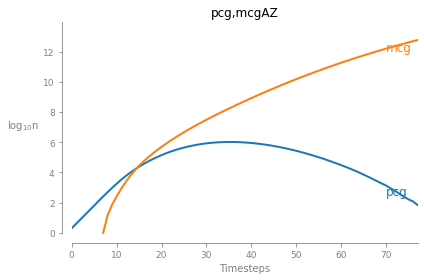

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

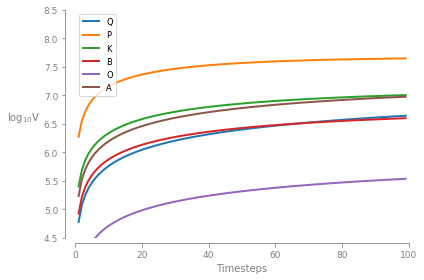

After 70 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


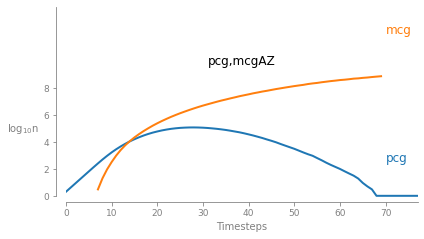

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

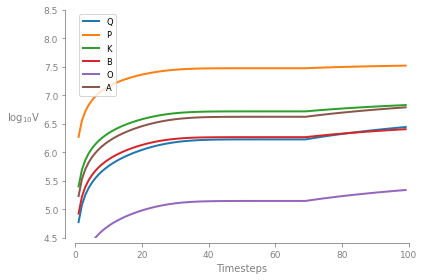

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 4
too few P -1
too few K -2
too few B -1
too much O 1
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 70 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


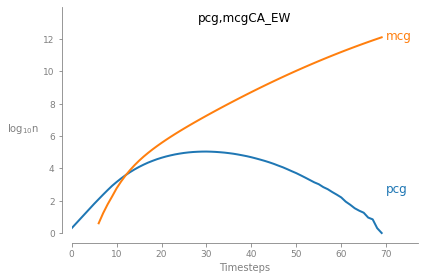

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

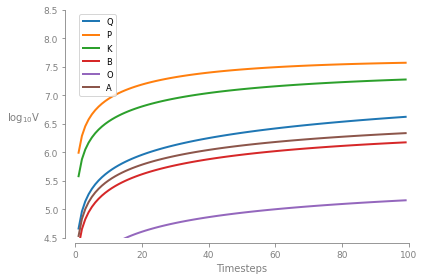

After 57 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


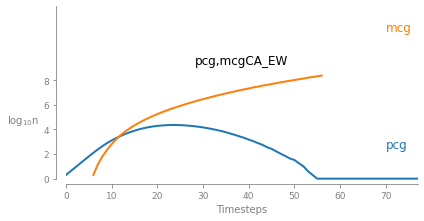

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

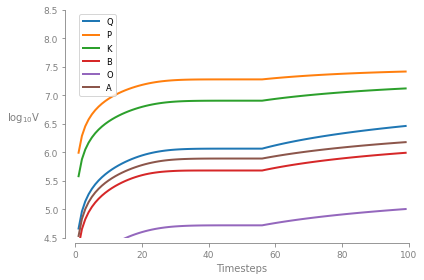

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 4
too few P -3
all good K 0
too few B -1
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 65 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


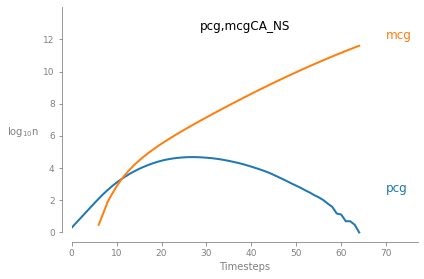

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

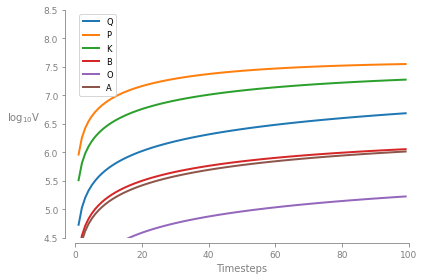

After 57 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


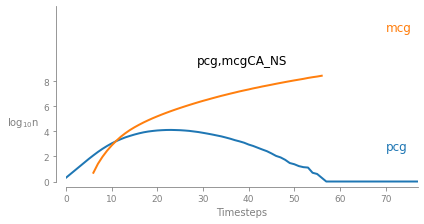

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

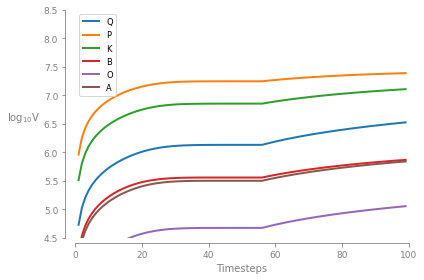

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
all good P 0
all good K 0
all good B 0
all good O 0
too few A -9
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 84 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


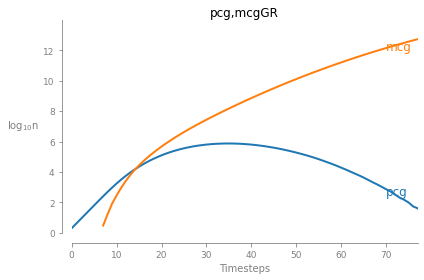

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

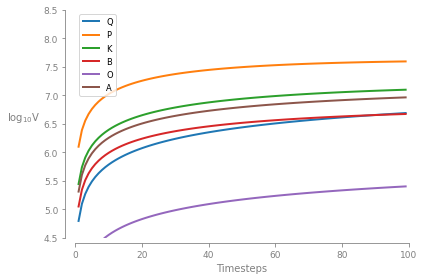

After 68 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


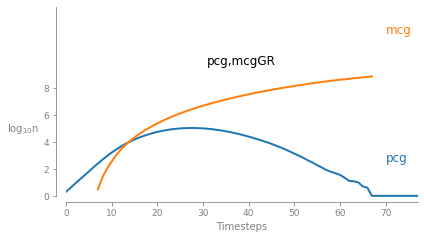

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

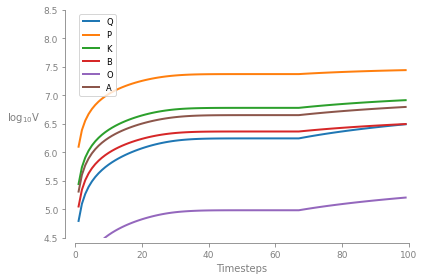

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 8
too few P -7
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 79 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


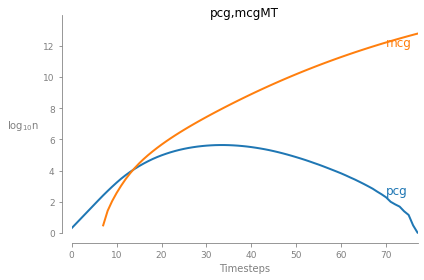

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

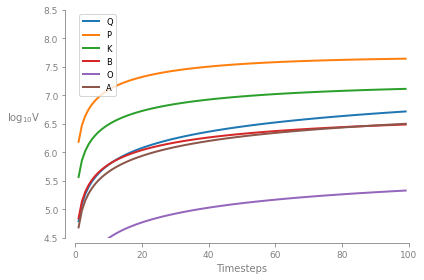

After 62 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


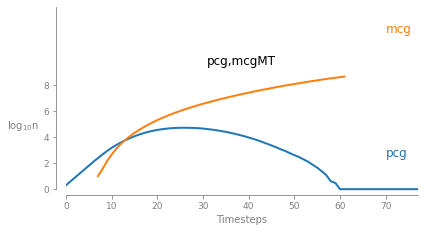

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

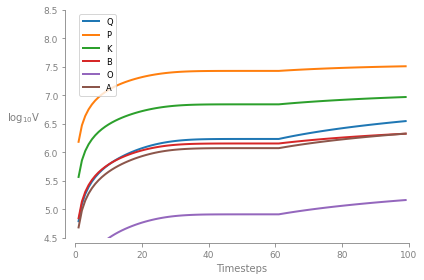

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
too few P -1
all good K 0
too few B -1
too few O -4
too few A -3
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 79 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


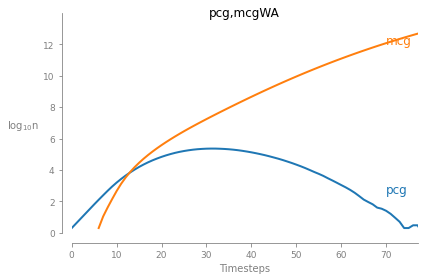

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

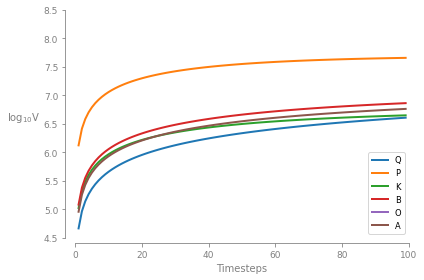

After 63 steps all pcgs have been broken down to mcg


<ipython-input-46-8862124b8360>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


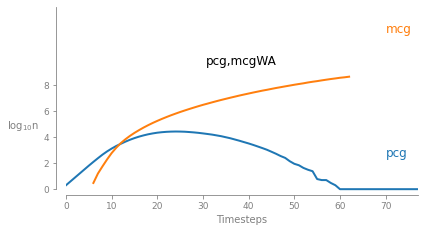

<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f157e222>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.minerals[i], lw=2)
<ipython-input-47-8830f15

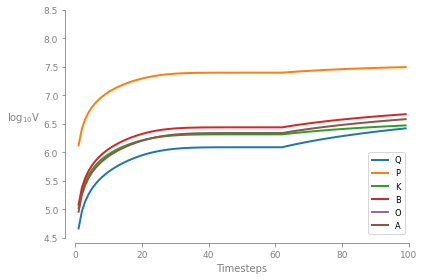

Wall time: 37min 12s


In [48]:
%%time
for i in range (6):
    #sedgen running for every pluton
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[i], csds_means[i], csds_stds[i],
                    learning_rate = 10000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03])
        #establishing plutonname
    pluton = plutonname(i)
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech)
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen)
        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen)
    